In [1]:
import psycopg2
import torch
import numpy as np
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Connect to PostgreSQL
conn = psycopg2.connect(
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT")
)
cursor = conn.cursor()

# Retrieve embeddings from the test set
cursor.execute("SELECT embedding, label FROM test_text_embeddings WHERE embedding IS NOT NULL")
rows = cursor.fetchall()

# Convert embeddings back into tensors
test_embeddings, test_labels = [], []

for embedding_str, label in rows:
    embedding_list = list(map(float, embedding_str.split(",")))  # Convert string to list
    test_embeddings.append(torch.tensor(embedding_list, dtype=torch.float32))
    test_labels.append(label)

# Stack embeddings into a single tensor
test_embeddings_tensor = torch.stack(test_embeddings).to("cuda")
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

print(f"✅ Loaded {len(test_embeddings_tensor)} test samples from PostgreSQL.")
print(f"✅ Loaded {len(test_labels_tensor)} test labels from PostgreSQL.")

✅ Loaded 3000 test samples from PostgreSQL.
✅ Loaded 3000 test labels from PostgreSQL.


In [2]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

# Define SAE model
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Load the model architecture
sae = SparseAutoencoder(input_dim=test_embeddings_tensor.shape[1], hidden_dim=128).to("cuda")

# Load the saved model weights
sae.load_state_dict(torch.load("sparse_autoencoder.pth"))
sae.eval()

print("✅ SAE model loaded successfully!")


✅ SAE model loaded successfully!


In [3]:
# Extract features from test set
sae.eval()
with torch.no_grad():
    test_features = sae.encoder(test_embeddings_tensor).cpu().numpy()  # Move to CPU for XGBoost

print(f"✅ Extracted test features shape: {test_features.shape}")
print(f"✅ Extracted test features successfully!")

✅ Extracted test features shape: (3000, 128)
✅ Extracted test features successfully!


In [4]:
import joblib
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the trained XGBoost model
xgb_model = joblib.load("xgboost_classifier.pkl")

# Predict on test set
test_preds = xgb_model.predict(test_features)

# Compute evaluation metrics
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)

print("\n📊 XGBoost Test Set Performance:")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print("\n✅ Evaluation metrics computed successfully!")


📊 XGBoost Test Set Performance:
✅ Accuracy: 0.7887
✅ Precision: 0.7801
✅ Recall: 0.8040
✅ F1 Score: 0.7919

✅ Evaluation metrics computed successfully!


d:\projects\aitext\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


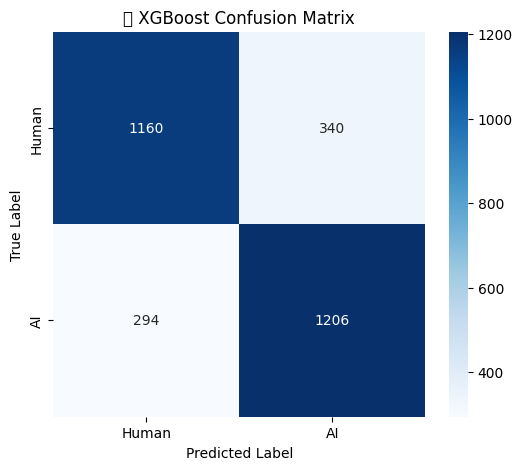

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("📊 XGBoost Confusion Matrix")
plt.show()


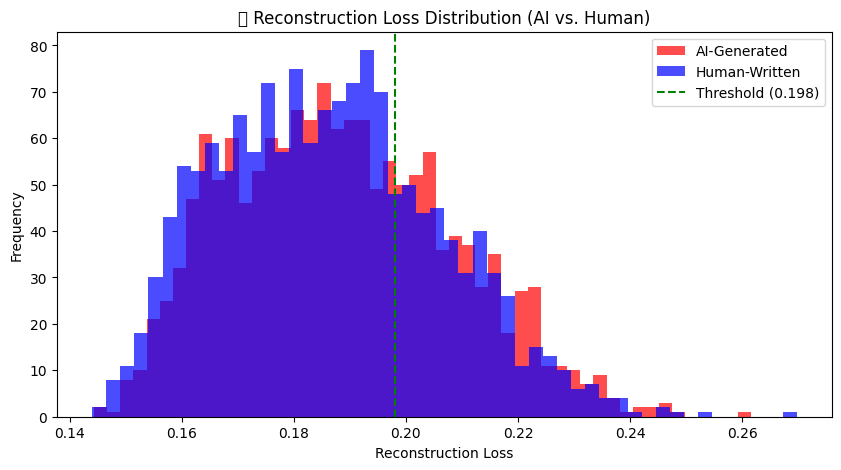

In [6]:
import numpy as np

def detect_ai_text(model, test_embeddings, threshold=0.198):
    """
    Uses the Sparse Autoencoder to classify AI-generated text.
    - Computes reconstruction loss.
    - Labels as AI-generated if loss is below threshold.
    """
    with torch.no_grad():
        reconstructed, _ = model(test_embeddings)  # Forward pass through SAE
        reconstruction_loss = torch.mean((test_embeddings - reconstructed) ** 2, dim=1)  # MSE loss per sample

    # Convert to CPU for further processing
    reconstruction_loss = reconstruction_loss.cpu().numpy()

    # Classify based on threshold
    predictions = (reconstruction_loss > threshold).astype(int)  # 1 = AI, 0 = Human

    return reconstruction_loss, predictions

# Compute reconstruction loss on test data
test_reconstruction_loss, _ = detect_ai_text(sae, test_embeddings_tensor)

# Separate AI vs Human losses
ai_losses = test_reconstruction_loss[np.array(test_labels) == 1]
human_losses = test_reconstruction_loss[np.array(test_labels) == 0]

# Plot distributions
plt.figure(figsize=(10, 5))
plt.hist(ai_losses, bins=50, alpha=0.7, label="AI-Generated", color="red")
plt.hist(human_losses, bins=50, alpha=0.7, label="Human-Written", color="blue")
plt.axvline(x=0.198, color='green', linestyle="--", label="Threshold (0.198)")
plt.xlabel("Reconstruction Loss")
plt.ylabel("Frequency")
plt.title("📊 Reconstruction Loss Distribution (AI vs. Human)")
plt.legend()
plt.show()


d:\projects\aitext\venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\projects\aitext\venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\ernan\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ernan\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\ernan\AppData\Local\Programs\Python\Python311\L

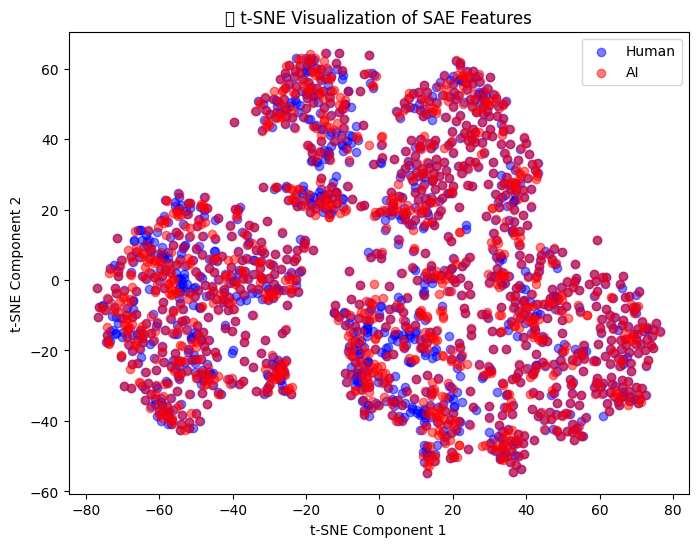

In [7]:
from sklearn.manifold import TSNE

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
test_features_2d = tsne.fit_transform(test_features)

# Plot t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(test_features_2d[np.array(test_labels) == 0, 0], test_features_2d[np.array(test_labels) == 0, 1], 
            c="blue", label="Human", alpha=0.5)
plt.scatter(test_features_2d[np.array(test_labels) == 1, 0], test_features_2d[np.array(test_labels) == 1, 1], 
            c="red", label="AI", alpha=0.5)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("📊 t-SNE Visualization of SAE Features")
plt.legend()
plt.show()


d:\projects\aitext\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


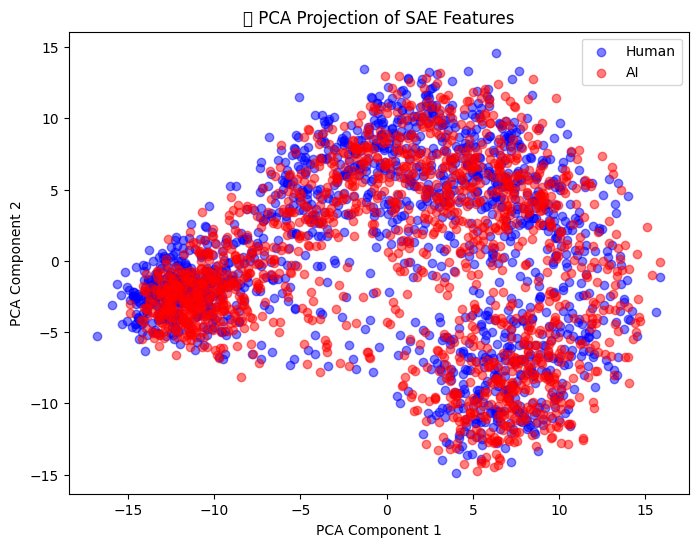

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce SAE features to 2D using PCA
pca = PCA(n_components=2)
test_features_pca = pca.fit_transform(test_features)

# Plot PCA
plt.figure(figsize=(8, 6))
plt.scatter(test_features_pca[np.array(test_labels) == 0, 0], test_features_pca[np.array(test_labels) == 0, 1], 
            c="blue", label="Human", alpha=0.5)
plt.scatter(test_features_pca[np.array(test_labels) == 1, 0], test_features_pca[np.array(test_labels) == 1, 1], 
            c="red", label="AI", alpha=0.5)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("📊 PCA Projection of SAE Features")
plt.legend()
plt.show()
